## READ THIS:

This notebook shows the user how to drive the MJOcast on a single forecast file, and create desired output file. 

In this example, the output file has lead-time dependent bias removed, based on the lead time dependent climo file.

This forecast file climo file was made with teh Preprocessing_Tools, and MUST be completed prior to making this work on your files

### Import Packages

In [4]:
import MJOcast.utils.ProcessForecasts as ProFo 
import MJOcast.utils.ProcessOBS as ProObs
import MJOcast.utils.WHtools as WHtools
import importlib
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

## Some Description Functions

In [43]:
def is_numeric_dtype(da):
    # Check if the data type of the DataArray is numeric
    return np.issubdtype(da.dtype, np.number)

def ds_describe(dataset):
    data = {
        'Variable Name': [],
        'Number of Dimensions': [],
        'Number of NaNs': [],
        'Mean': [],
        'Median': [],
        'Standard Deviation': [],
        'Minimum': [],
        '25th Percentile': [],
        '75th Percentile': [],
        'Maximum': []
    }

    for var_name in dataset.variables:
        # Get the data array
        data_array = dataset[var_name]

        # Check if the data type is numeric
        if is_numeric_dtype(data_array):

            flat_data_array = data_array.values.flatten()

            # Append statistics to the data dictionary
            data['Variable Name'].append(var_name)
            data['Number of Dimensions'].append(data_array.ndim)
            data['Number of NaNs'].append(np.isnan(flat_data_array).sum())
            data['Mean'].append(np.nanmean(flat_data_array))
            data['Median'].append(np.nanmedian(flat_data_array))
            data['Standard Deviation'].append(np.nanstd(flat_data_array))
            data['Minimum'].append(np.nanmin(flat_data_array))
            data['25th Percentile'].append(np.nanpercentile(flat_data_array, 25))
            data['75th Percentile'].append(np.nanpercentile(flat_data_array, 75))
            data['Maximum'].append(np.nanmax(flat_data_array))

    # Create a pandas DataFrame from the data dictionary
    df = pd.DataFrame(data)

    return df

## The example file is stored here: 

However you can have multiple forecast files in each a location. 

- /glade/campaign/cgd/amp/wchapman/MJO_S2S_CESM2/p1/examples/S2Shindcast_cesm2cam6vs_MJOvars_25jan2018.nc
- - using a wild card will allow you to process many files: 
- - - /glade/campaign/cgd/amp/wchapman/MJO_S2S_CESM2/p1/examples/S2Shindcast_cesm2cam6vs_*.nc


## This is what your input file should looks like:
 - the dimension order and lat/lon orientation should not matter

In [26]:
DSin = xr.open_dataset('/glade/campaign/cgd/amp/wchapman/MJO_S2S_CESM2/p1/examples/S2Shindcast_cesm2cam6vs_MJOvars_25jan2018.nc')
ds_describe(DSin)

,Variable Name,Number of Dimensions,Number of NaNs,Mean,Median,Standard Deviation,Minimum,25th Percentile,75th Percentile,Maximum
0,lat,1,0,0.000000,0.000000,52.249401,-90.000000,-45.000000,45.000000,90.000000
1,lon,1,0,179.500000,179.500000,103.922646,0.000000,89.750000,269.250000,359.000000
2,ua_200,4,0,15.059745,12.379210,17.571800,-46.959614,2.113728,26.330645,105.739685
3,ua_850,4,0,1.133041,0.260850,8.439071,-43.622723,-4.955983,6.332463,44.975014
4,va_200,4,0,0.370263,0.273217,11.337876,-65.868439,-6.042417,6.943476,77.773819
5,va_850,4,0,-0.000132,-0.097395,5.825681,-45.524876,-3.407804,3.331286,41.681896
6,rlut,4,0,221.043411,215.677765,45.085003,87.728996,181.913101,262.482300,352.204224


In [27]:
DSin

<xarray.Dataset>
Dimensions:  (time: 46, lat: 181, lon: 360, ensemble: 11)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-25 2018-01-26 ... 2018-03-11
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Dimensions without coordinates: ensemble
Data variables:
    ua_200   (ensemble, time, lat, lon) float32 -6.05 -6.055 ... 6.014 6.302
    ua_850   (ensemble, time, lat, lon) float32 -1.463 -1.409 ... 1.393 1.507
    va_200   (ensemble, time, lat, lon) float32 0.3324 0.2267 ... 16.54 16.43
    va_850   (ensemble, time, lat, lon) float32 -3.055 -3.08 ... 6.527 6.502
    rlut     (ensemble, time, lat, lon) float32 179.6 179.6 ... 173.2 173.2
Attributes:
    ensemblepath_u200:  ['/glade/campaign/cesm/development/cross-wg/S2S/CESM2...
    ensemblepath_u850:  ['/glade/campaign/cesm/development/cross-wg/S2S/CESM2...
    ensemblepath_rlut:  ['/glade/campaign/cesm/development/cross-wg/S2S/CESM2...

## First Create your Driver YAML file:

In [6]:
# YAML file specifying output configuration
output_yaml = 'output.yaml'

# User information
user_ = 'wchapman'

# Base directory
base_dir = '/glade/work/wchapman/MJOcast/MJOcast'

# Flag to indicate whether to use ERA5 data
use_era5 = True

# Alternative name for user-defined observations (only applicable if user_era5=False)
usr_named_obs = 'alternative_name_of_obs.nc'

# Locations for observation and forecast data
obs_data_loc = './Observations/'

# Locations for observation and forecast data
forecast_data_loc = '/glade/campaign/cgd/amp/wchapman/MJO_S2S_CESM2/p1/examples'

# String pattern for MJO forecast data files
forecast_data_name_str = 'S2Shindcast_cesm2cam6vs_MJOvars_*.nc'

# Variable names for forecast data (and name of ensemble dimension)
forecast_olr_name = 'rlut'
forecast_u200_name = 'ua_200'
forecast_u850_name = 'ua_850'
forecast_ensemble_dimension_name = 'ensemble'

# Location for diagnostic plots
output_plot_loc = './output_plots/'

# Location for output files
output_files_loc = '/glade/campaign/cgd/amp/wchapman/MJO_S2S_CESM2/RMM_forecast/ERA5/'

# Naming convention for MJO forecasts
output_files_string = '/MJO_Forecast_Init'

# Flag to indicate whether to use forecast climatology (turn False if you don't want to remove lead time dependent bias).
use_forecast_climo = True

# Flag to indicate whether to use observed climatology
# (always false if "use_forecast_climo=true")
use_observed_climo = False

# Flag to regenerate climatology
regenerate_climo = False

# Flag to use Dask for climatology on a single node/machine
use_dask_for_climo = True

# Flag to regenerate climatology (single node/machine)
regenerate_climo = False

#create your driver yaml file: 
WHtools.Create_Driver_Yaml('output.yaml', user_, base_dir, use_era5, usr_named_obs, obs_data_loc, forecast_data_loc, forecast_data_name_str, 
           forecast_olr_name, forecast_u200_name, forecast_u850_name, forecast_ensemble_dimension_name, 
           output_plot_loc, output_files_loc, output_files_string, use_forecast_climo, use_observed_climo, 
           regenerate_climo, use_dask_for_climo)

## Run your example and create your processed file: 

In [7]:
#initialize the ObsProcessor:
MJO_obs = ProObs.MJOobsProcessor(output_yaml)

#Make the Observed MJO file:
OBS_DS, eof_list, pcs, MJO_fobs, eof_dict = MJO_obs.make_observed_MJO()

#Plot whatever day you would like for the obs phase space:
MJO_obs.plot_phase_space('2001-01-01',60)

#Now initialize the 
MJO_for = ProFo.MJOforecaster(output_yaml,MJO_obs.eof_dict,MJO_obs.MJO_fobs)

#Now create the forecasts
DS_CESM_for,OLR_cesm_anom_filterd,U200_cesm_anom_filterd,U850_cesm_anom_filterd = MJO_for.create_forecasts(num_files=1)

#plot the phase space diagram for your forecast: 
MJO_for.plot_phase_space(12,15)

Number of forecast files to process: 1
expanding coords to include ensemble
ensemble dimension length: 11
there are 46 forecast lead days in these files
Initial look at forecast files passes the first test
 ----- Taking the EOF ----- 
...done making observed EOFS, check ./output_plots/*.png for verification metrics...
...attaching the BOM index for verification...
...saved OLR obs file...
Number of forecast files to process: 1
expanding coords to include ensemble
ensemble dimension length: 11
there are 46 forecast lead days in these files
Initial look at forecast files passes the first test
Using the forecast dependent climatology. Make sure you have generated it using ./Preprocessing_Scripts/*.ipynb.
reading forecasts file: /glade/campaign/cgd/amp/wchapman/MJO_S2S_CESM2/p1/examples/S2Shindcast_cesm2cam6vs_MJOvars_25jan2018.nc
expanding coords to include ensemble
ensemble dimension length: 11
there are 46 forecast lead days in these files
---- doing anomaly ----
im using the LT dp clim

## Here is the created dataset

In [48]:
DSdone = xr.open_dataset('/glade/campaign/cgd/amp/wchapman/MJO_S2S_CESM2/RMM_forecast/ERA5//MJO_Forecast_Init_25jan2018.nc')
ds_describe(DSdone)

,Variable Name,Number of Dimensions,Number of NaNs,Mean,Median,Standard Deviation,Minimum,25th Percentile,75th Percentile,Maximum
0,RMM1,2,0,-0.805804,-0.966213,1.390877,-3.907686,-1.792831,-0.110695,2.526536
1,RMM2,2,0,1.156280,1.291789,1.571479,-3.163545,0.008305,2.372178,4.214555
2,RMM1_emean,1,0,-0.805804,-1.176690,1.179169,-2.106506,-1.517038,-0.678916,2.109131
3,RMM2_emean,1,0,1.156280,1.400758,1.302511,-0.949654,-0.021945,1.925118,3.347374
4,RMM1_obs,1,0,-0.090976,-0.432955,1.176259,-1.932347,-0.607669,0.295254,2.804691
5,RMM2_obs,1,0,0.795382,0.862105,1.790260,-1.815359,-1.116627,2.605077,3.469846
6,eofs_save,3,0,0.092458,0.071223,1.412497,-5.157278,-0.865444,1.063685,4.589880
7,OLR_norm,3,0,0.088420,0.146367,1.388806,-6.453241,-0.697926,0.904187,5.794934
8,eof1_olr,1,0,0.001003,0.005547,0.019476,-0.048480,-0.004137,0.015494,0.027635
9,eof2_olr,1,0,0.004015,-0.004814,0.017875,-0.013825,-0.007608,0.008004,0.057309


In [49]:
DSdone

<xarray.Dataset>
Dimensions:                 (time: 46, number: 11, neigs: 15, longitude: 360)
Coordinates:
  * time                    (time) datetime64[ns] 2018-01-25 ... 2018-03-11
  * longitude               (longitude) float32 0.0 1.0 2.0 ... 358.0 359.0
  * neigs                   (neigs) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Dimensions without coordinates: number
Data variables: (12/19)
    RMM1                    (time, number) float64 1.603 1.839 ... -0.2125
    RMM2                    (time, number) float64 0.8348 0.2453 ... -0.2547
    RMM1_emean              (time) float32 1.611 1.97 2.015 ... -0.6209 -0.5538
    RMM2_emean              (time) float32 0.8232 1.017 1.034 ... -0.7507 -0.651
    RMM1_obs                (time) float32 2.169 2.384 ... -0.09171 -0.2801
    RMM2_obs                (time) float32 0.343 0.4311 ... -1.105 -0.9585
    ...                      ...
    eof2_u200               (longitude) float32 0.04931 0.04929 ... 0.04912 0.0
    u200_norm               (time, number, longitude) float64 1.689 ... 0.0
    u850_norm               (time, number, longitude) float64 -0.2714 ... 0.0
    U200_cesm_anom          (number, time, longitude) float32 9.619 ... -0.8669
    U200_cesm_anom_filterd  (number, time, longitude) float32 8.712 ... -2.494
    eig_vals                (neigs) float32 137.7 133.8 63.01 ... 16.92 16.78
Attributes:
    title:        MJO RMM Forecast the projected eof(u850,u200,OLR)
    description:  MJO Forecast in the Prescribed Forecast dataset calculated ...
    notes:        ONLY Variables RMM1 and RMM2 have been flipped and switched...

## The output plots are saved in the specified directory

### EOFS of obs:

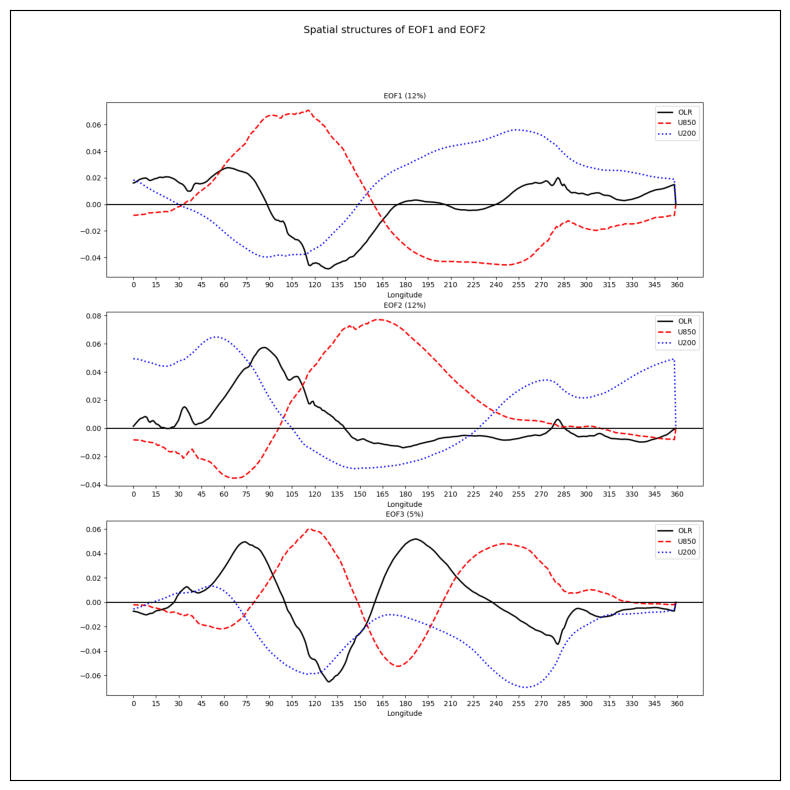

In [22]:
plt.figure(figsize=(10,10))
image = mpimg.imread("./output_plots/observed_eofs.png")
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

## Phase Space of the forecast and Obs:
- ensemble mean = thick red line 
- ensembles: thin lines 
- obs: colored lines

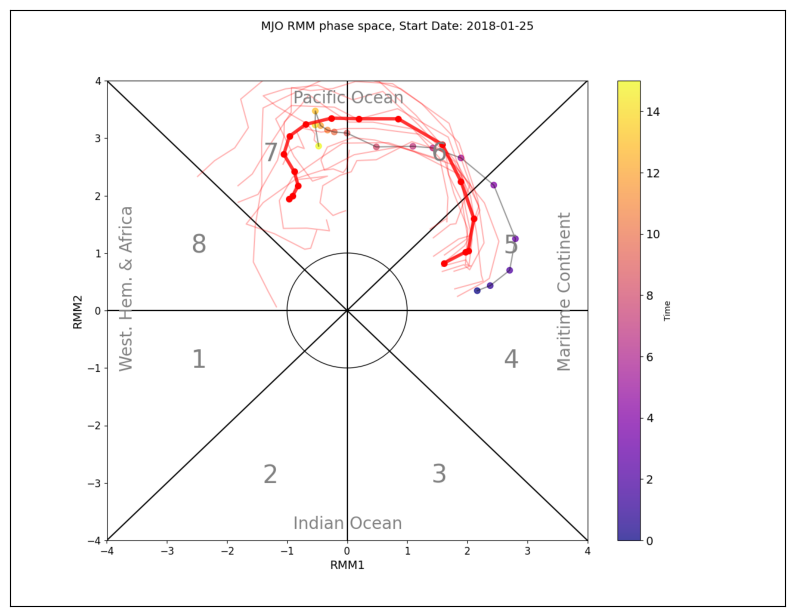

In [24]:
plt.figure(figsize=(10,10))
image = mpimg.imread("./output_plots/phase_space_MJO_forecast_2018-01-25.png")
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()